# Mistral's Codestral with code interpreting and analyzing dataset
**Powered by open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

Read more about Mistral's new Codestral model [here](https://mistral.ai/news/codestral/).

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker). Inside this sandbox is a running Jupyter server that the LLM can use.

### Step 1: Install dependencies

We start by installing the [E2B code interpreter SDK](https://github.com/e2b-dev/code-interpreter) and [Mistral's Python SDK](https://console.mistral.ai/).

In [53]:
%pip install mistralai e2b_code_interpreter

Note: you may need to restart the kernel to use updated packages.


### Step 2: Define API keys and prompt

Let's define our variables with API keys for Mistral and E2B together with the model ID and prompt. We won't be defining any tools because Codestral doesn't support tool usage yet.

In [54]:
# TODO: Get your Mistral API key from https://console.mistral.ai
MISTRAL_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""

MODEL_NAME = "codestral-latest"

SYSTEM_PROMPT = """You're a python data scientist that is analyzing daily temperature of major cities. You are given tasks to complete and you run Python code to solve them.

Information about the temperature dataset:
- It's in the `/home/user/city_temperature.csv` file
- The CSV file is using `,` as the delimiter
- It has following columns (examples included):
  - `Region`: "North America", "Europe"
  - `Country`: "Iceland"
  - `State`: for example "Texas" but can also be null
  - `City`: "Prague"
  - `Month`: "June"
  - `Day`: 1-31
  - `Year`: 2002
  - `AvgTemperature`: temperature in Celsius, for example 24

Generally, you follow these rules:
- ALWAYS FORMAT YOUR RESPONSE IN MARKDOWN
- ALWAYS RESPOND ONLY WITH CODE IN CODE BLOCK LIKE THIS:
```python
{code}
```
- the python code runs in jupyter notebook.
- every time you generate python, the code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to be running `!pip install {package}`. The usual packages for data analysis are already preinstalled though.
- you can run any python code you want, everything is running in a secure sandbox environment
"""

Because Codestral doesn't support function calling yet, we instruct the model to return messages in Markdown and then parse and extract the Python code block on our own.

In [55]:
import re
pattern = re.compile(r'```python\n(.*?)\n```', re.DOTALL) # Match everything in between ```python and ```
def match_code_block(llm_response):
  match = pattern.search(llm_response)
  if match:
    code = match.group(1)
    print(code)
    return code
  return ""

### Step 3: Implement the method for code interpreting

Here's the main function that uses the E2B code interpreter SDK. We'll be calling this function a little bit further when we're parsing the Codestral's response with tool calls.

In [56]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

### Step 4: Implement the method for calling Codestral and parsing its response

Now we're going to define and implement `chat` method. In this method, we'll call the Codestral LLM, parse the output to extract any Python code block, and call our `code_interpret` method we defined above.

In [57]:
from mistralai.client import MistralClient

client = MistralClient(api_key=MISTRAL_API_KEY)

def chat(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  # Codestral doesn't support tools/function calling yet
  response = client.chat(
      model=MODEL_NAME,
      messages=messages,
  )
  response_message = response.choices[0].message
  python_code = match_code_block(response_message.content)
  if python_code != "":
    code_interpreter_results = code_interpret(e2b_code_interpreter, python_code)
    return code_interpreter_results
  else:
    print(f"Failed to match any Python code in model's response {response_message}")
    return[]

### Step 5: Implement method for uploading dataset to code interpreter sandbox

The file gets uploaded to the E2B sandbox where our code interpreter is running. We get the file's remote path in the `remote_path` variable.

In [58]:
def upload_dataset(code_interpreter):
  print("Uploading dataset to Code Interpreter sandbox...")
  with open("./city_temperature.csv", "rb") as f:
    remote_path = code_interpreter.upload_file(f)
  print("Uploaded at", remote_path)

### Step 6: Put everything together

In this last step, we put all the pieces together. We instantiate a new code interpreter instance using

```py
with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
```

and then call the `chat` method with our user message and the `code_interpreter` instance.

Uploading dataset to Code Interpreter sandbox...
Uploaded at /home/user/city_temperature.csv

User message: Plot average temperature over the years in Algeria
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/home/user/city_temperature.csv')

# Filter the data for Algeria
df_algeria = df[df['Country'] == 'Algeria']

# Group the data by year and calculate the average temperature
df_algeria_yearly = df_algeria.groupby('Year')['AvgTemperature'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_algeria_yearly.index, df_algeria_yearly.values)
plt.title('Average Temperature Over the Years in Algeria')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celsius)')
plt.show()
Running code interpreter...


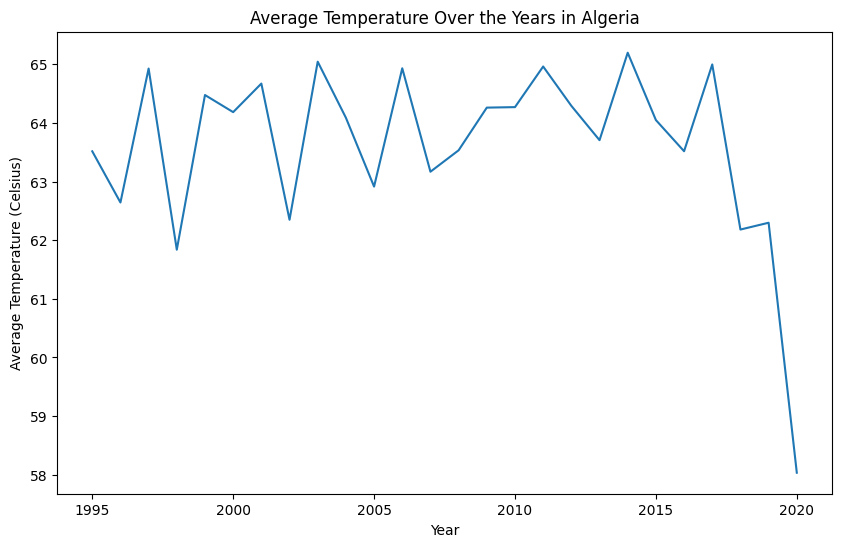

In [59]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat(
    code_interpreter,
    "Plot average temperature over the years in Algeria"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code interpreter results")


# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result